# Super Resolution 저해상도의 이미지를 고해상도 이미지로 변환


GAN 관련 기술이 일반적인 CNN 기술보다 훨씬 정밀한 고해상도 이미지를 생성해 내는 데 효과적입니다. 

하지만 고화질의 이미지를 생성해 내는 GAN 모델을 학습하는 것은 오랜 시간이 소요되는 과정입니다.


오늘은 모델학습 과정 자체보다는 모델의 구조와 특성, 그리고 잘 학습된 모델을 활용한 고해상도 변환을 체험하는 데 보다 중점을 두어 진행하게 될 것입니다.

**학습 목표**

- Super Resolution과 그 과정 수행에 필요한 기본 개념을 이해합니다.

- Super Resolution에 사용되는 대표적인 2개의 구조(SRCNN,
SRGAN)에 대해 이해하고 활용합니다.

<br>

**학습 전제**

- 신경망의 학습 방법에 대한 전반적인 절차를 알고 있어야 합니다.

- CNN, GAN에 대한 기본적인 개념을 알고 있어야 합니다.

- Tensorflow에서 모델을 구성할 때 사용하는 Sequential,
Functional API에 대해 알고 있어야 합니다.

- Tensorflow의 GradientTape API를 이용한 학습 절차를 이해할 수 있어야 합니다.

목차

1. 가장 쉬운 Super Resolution
2. Deep Learning을 이용한 Super Resolution (1) SRCNN
3. Deep Learning을 이용한 Super Resolution (2) SRCNN 이후
제안된 구조들
4. SRCNN을 이용해 Super Resolution 도전하기
5. Deep Learning을 이용한 Super Resolution (3) SRGAN
6. SRGAN을 이용해 Super Resolution 도전하기
7. Super Resolution 결과 평가하기
8. SRCNN 및 SRGAN 결과 비교하기

In [ ]:
import pandas as pd
import numpy as np

import tensorflow_datasets as tfds
tfds.load("div2k/bicubic_x4")

## 가장 쉬운 Super Resolution

(300, 451, 3)


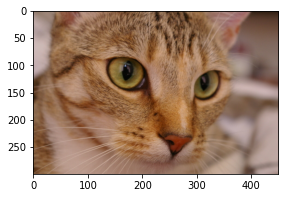

In [3]:
from skimage import data
import matplotlib.pyplot as plt

hr_image = data.chelsea() # skimage에서 제공하는 예제 이미지를 불러옵니다.
hr_shape = hr_image.shape[:2]

print(hr_image.shape) # 이미지의 크기를 출력합니다.
plt.figure(figsize=(6,3))
plt.imshow(hr_image)

이 고양이 이미지의 크기는 가 300 x 451 x 3 으로 확인되네요.
Interpolation을 통해 고양이를 매우 쉽게 Super Resolution 해보겠습니다.

(세로 픽셀 수 x 가로 픽셀 수 x 채널 수)

우선 불러온 고양이가 꽤나 선명하기 때문에 일부러 크기를 줄여 저해상도로 낮춰보겠습니다.

opencv 라이브러리의 resize() 를 이용해 이미지의 크기를 조절할수 있습니다. 아래 코드에서는 고양이를 '100 x 150 x 3' 크기로 줄입니다. 


dsize의 설정값에 따라 크기를 조절하는데, 주의할 점은 변환하고자
하는 이미지의 크기를 로 지정해줘야 합니다.

(100, 150, 3)


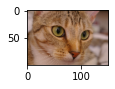

In [4]:
import cv2
lr_image = cv2.resize(hr_image, dsize=(150,100)) # (가로 픽셀 수, 세로 픽셀 수)
print(lr_image.shape)
plt.figure(figsize=(3,1))
plt.imshow(lr_image)

작아진 고양이 이미지로 Interpolation 방법을 적용해 Super Resolution을 시도해보겠습니다.


resize()내의 설정에 따라 적용 방법을 조절할 수 있습니다. 

아래 코드는 이전에 간략하게 알아보았던 bilinear 및 bicubic interpolation을 적용해 이미지를 '400 x 600 x 3' 크기로
크게 변환하는 예제입니다.

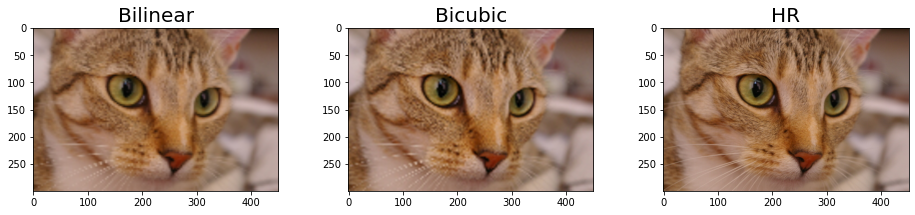

In [5]:
bilinear_image = cv2.resize(
lr_image,
dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수)
interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)
bicubic_image = cv2.resize(
lr_image,
dsize=(451, 300), # (가로 픽셀 수, 세로 픽셀 수)
interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)
images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]
plt.figure(figsize=(16,3))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)


이외 다른 interpolation 방법을 적용하고 싶다면 아래 링크를 참고해 주세요.

https://www.google.com/url?sa=D&q=https://docs.opencv.org/master/da/d54/group__imgproc__transform.html%23ga5bb5a1fea74ea38e1a5445ca803ff121&ust=1663077180000000&usg=AOvVaw3oh-w453m58_knHmgMOS1l&hl=ko


Bilinear 및 bicubic interpolation을 적용한 이미지와 원래 고해상도 이미지(위 그림의 HR)를 시각화했습니다. 

이미지가 작아 시각적으로 해상도에 큰 차이가 없어 보입니다. 

아래 코드를 이용해 특정 부분을 잘라내어 시각화해 봅시다.

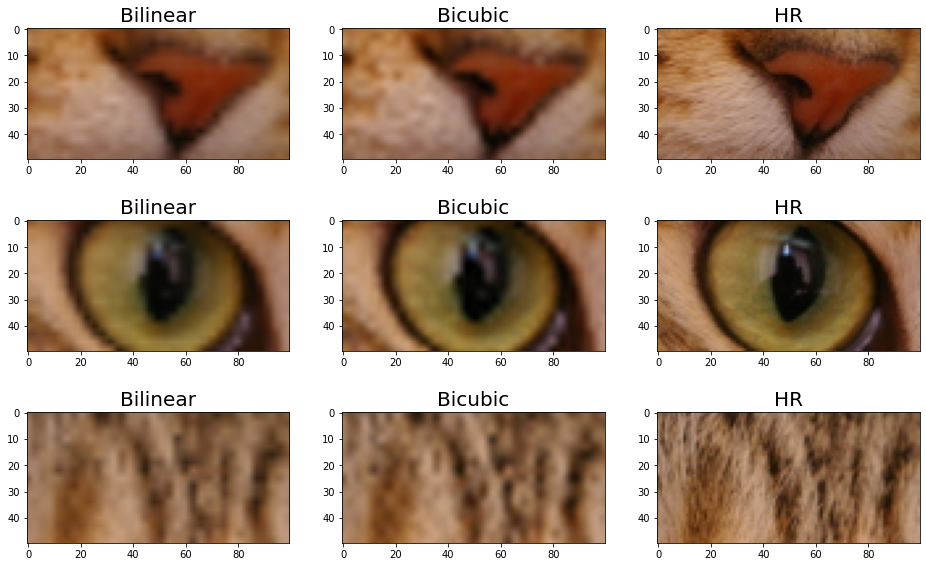

In [6]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(220,200)] *3 + [(90,120)] *3 + [(30,200)] *3
plt.figure(figsize=(16,10))

for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)

Interpolation 방법을 이용한 Super Resolution 결과는 어떤가요? 

이미지만 크게 만들어줄 뿐 세밀한 정보는 거의 찾아볼 수 없는 것을 확인할 수 있습니다.


위와 같은 interpolation 방법은 많은 딥러닝 기반 Super Resolution 연구에서 결과를 비교하기 위해 수행됩니다.

이제부터는 딥러닝 기반 Super Resolution에 대해 간략히 알아보고 실험해 보겠습니다.


그리고 방금 수행한 interpolation 방법과 비교하여 딥러닝을 사용하는 것이 얼마나 성능이 좋은지 한번 직접 느껴봅시다!

---

## Deep Learning을 이용한 Super Resolution: SRCNN

SRCNN은 2014년 발표된 "Image Super-Resolution Using Deep Convolutional Networks"논문에서 사용되었습니다.




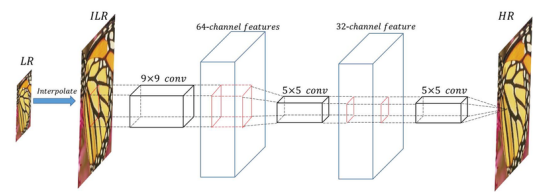

가장 먼저 저해상도 이미지(그림의 LR)를 bicubic interpolation 하여 원하는 크기로 이미지를 늘립니다. 

SRCNN은 이 이미지(그림의 ILR)를 입력으로 사용합니다. 

이후 3개의 convolutional layer를 거쳐 고해상도 이미지를 생성해 냅니다. 

생성된 고해상도 이미지와 실제 고해상도 이미지 사이의 차이를 역전파 하여 신경망의 가중치를 학습합니다. 최근 발표되는 수 백 개 이상의 convolutional layer를 갖는 CNN과 비교하면 SRCNN은 매우 간단합니다.


SRCNN이 발표된 지 꽤 오랜 시간이 흘렀고, 딥러닝 기반 Super Resolution분야에서 대표적인 연구로 꼽히는 만큼 이 연구에 대해 정리된 자료들이 매우 많습니다. 

아래 SRCNN에 대해 설명한 참고 자료를 읽고 질문에 답해봅시다.(Experiments 이전까지만 보시면 됩니다)

https://d-tail.tistory.com/6

**SRCNN은 3가지 연산으로 구성되고 간략하게 설명된다.**

1. Patch extraction and representation : 저해상도
이미지에서 patch를 추출한다.

2. Non-linear mapping : Patch를 다른 차원의
patch로 비선형 매핑한다.

3. Reconstruction : Patch로부터 고해상도 이미지를
생성한다.

---

### Deep Learning을 이용한 Super Resolution: SRCNN 이후 제안된 구조들


일반적인 CNN의 발전 과정과 크게 다르지 않으며, Super
Resolution뿐만 아니라 많은 컴퓨터 비전 분야에서 사용되는 방법들과 유사합니다.

**VDSR(Very Deep Super Resolution**

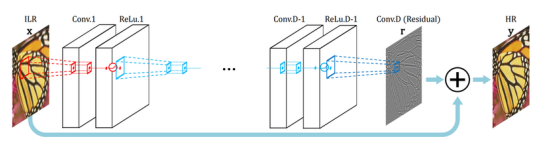

SRCNN과 동일하게 interpolation을 통해 저해상도 이미지의 크기를 늘려 입력으로 사용합니다. 

이전보다 훨씬 많은 20개의 convolutional layer를
사용했고, 최종 고해상도 이미지 생성 직전에 처음 입력 
이미지를 더하는 residual learning을 이용했습니다. 

이러한 깊은 구조를 이용해 SRCNN에 비해 큰 성능 향상을 이끌어 냈습니다.

**RDN(Residual Dense Network)**

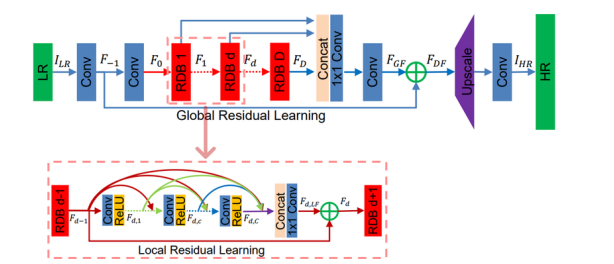

이전 구조보다 그림이 조금 복잡해졌습니다. 

RDN은 저해상도 이미지가 입력되면, 여러 단계의 convolutional layer를 거치는데 각 layer에서 나오는 출력을 최대한 활용하도록 합니다. 

그림과 같이 각각의 convolution layer 출력 결과로 생성된 특징들이 화살표를 따라 이후 연산에서 여러 번 재활용 하는 것을 볼 수 있습니다. (한 곳으로부터 나온 화살표가 여러 곳을
향하고 있습니다)

**RCAN(Residual Channel Attention Networks)**

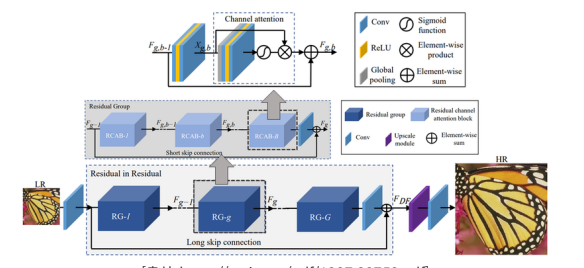

RCAN 구조 또한 많은 convolutional layer를 거치며 학습합니다. 

위 구조들과 다른 특별한 점은 convolutional layer의 결과인 각각의 특징 맵을 대상으로 채널 간의 모든 정보가 균일한
중요도를 갖는 것이 아니라 일부 중요한 채널에만 선택적으로 집중하도록 유도했습니다 

(맨 위의 Channel attention이라 쓰인 부분). CNN Attention
등의 키워드로 검색하면 RCAN 구조와 비슷한 많은 attention 기술에 대한 정보들을 찾아볼 수 있습니다.